# STA365 Homework 6

In [ ]:
# Import necessary modules
import random
import pymc as pm
import arviz as az
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests

In [ ]:
# Set directory to Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/STA365')
# Read dataset
df = pd.read_csv("study_performance.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Homework 6: Part I

1. Go get data from kaggle.com and do a ***(Univariate) Bayesian Logistic Regression*** analysis

2. Adjust the code below to specify that the outcomes have a Bernoulli distribution and use a ***logit*** or ***probit link function*** (or $\Pr(z\leq 0)$ for latent $z$ ) to correctly paramterize the predicted values of the observed outcomes

```python
import pymc as pm; import numpy as np
n,p=100,10; X,y=np.zeros((n,p)),np.ones((n,1))
# Replace this made up data with your data set from kaggle...
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=y)

with MLR:
    idata = pm.sample()
```    

3. Choose ***prior*** that are sensible for your specification

4. [Optional] Assess the performance of the MCMC and any issues or warnings in the [standard manner](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#pymc-overview)

4. [Optional] Go get data from kaggle.com and do a ***Multivariate Bayesian Logistic Regression*** analysis


## Data cleaning

In [ ]:
# Describe the first 5 rows to view the data
df.head(5)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Let's introduce the dataset first. I found this dataset from this website: https://www.kaggle.com/datasets/bhavikjikadara/student-study-performance. This is a cross-sectional dataset recording a group of students' test scores and other relevant covariates, such as their sex, ethnicity, parents' level of education, how well did they enjoy their lunch prior to the test, and whether they have completed a test preparation course.

We define the outcome of interest as a binary variable on whether the student passes the math test (obtaining higher than a passing grade of 50), and are interested in the linear relationship between the probability of passing and the set of covariates mentioned above.

In [ ]:
# Convert math score to a binary variable, and drop unnecessary variables
df['pass'] = (df['math_score'] >= 50).astype(int)
# Convert other variables to numerical values
df['sex'] = (df['gender'] == 'female').astype(int)
df['lunch'] = (df['lunch'] == 'standard').astype(int)
df['prep_course'] = (df['test_preparation_course'] == 'completed').astype(int)

In [ ]:
# Parental education is more tricky since it is not binary
# so need to manually establish the ordering here
conditions = [
    df['parental_level_of_education'] == 'some high school',
    df['parental_level_of_education'] == 'high school',
    df['parental_level_of_education'] == 'some college',
    df['parental_level_of_education'] == "associate's degree",
    df['parental_level_of_education'] == "bachelor's degree",
    df['parental_level_of_education'] == "master's degree",
]

choices = [0,1,2,3,4,5]

# Applying the case when logic
df['parent_education'] = np.select(conditions, choices, default='Unknown').astype(int)
# Axis = 1 means dropping columns, set = 0 for rows
# For ethnicity, it's categorical and sensitive, so we are not going to use it
df = df.drop(['math_score', 'reading_score', 'writing_score', 'gender',
              'test_preparation_course', 'race_ethnicity',
              'parental_level_of_education'], axis=1)

In [ ]:
# Take a look at clean dataset to check for mistakes
df.head(5)

,lunch,pass,sex,prep_course,parent_education
0,1,1,1,0,4
1,1,1,1,1,2
2,1,1,1,0,5
3,0,0,0,0,3
4,1,1,0,0,2


In [ ]:
# Define parameters, the design matrix and the outcome
n, p = df.shape[0], df.shape[1] - 1
X = np.hstack((np.ones((n, 1)),
               df[['lunch', 'sex', 'prep_course',
                   'parent_education']].values))
y = df['pass'].values
#y.shape = (n,1)

In [ ]:
with pm.Model() as logistic_model:
    betas = pm.Normal('betas', mu=0, sigma=50, shape=X.shape[1])
    # Linear combination of inputs and weights
    logits = pm.math.dot(X, betas)

    # Likelihood (sampling distribution) of observations
    observed = pm.Bernoulli('observed', pm.math.sigmoid(logits), observed=y)

with logistic_model:
    idata = pm.sample()

Note that I've selected weakly informative priors of $N(0,50)$ for all of the regression coefficients since I cannot find specific distribution estimated from other literature sources. I chose to use a normal prior because each predictor is possible to be positively or negatively correlated with whether the student passes the math test.

In [ ]:
# Generate summary statistics after model fitting
az.summary(idata, round_to=2)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.55,0.23,0.13,0.97,0.01,0.0,1140.08,1317.26,1.0
betas[1],1.85,0.21,1.48,2.25,0.00,0.0,1868.11,1476.19,1.0
betas[2],-0.61,0.20,-0.97,-0.23,0.00,0.0,1627.67,1367.25,1.0
betas[3],0.99,0.23,0.53,1.40,0.01,0.0,1840.14,1354.18,1.0
betas[4],0.25,0.07,0.12,0.38,0.00,0.0,1524.12,1349.09,1.0


Let's take one example of interpretation. For $\beta_1$, which is the regression coefficient for binary predictor 'sex', and the default sex is male, and $\hat\beta_1 = 1.85$ indicates that female students are on average having 1.85 greater log odds of passing the math test compared to male students. Notice that the r_hat statistics are all less than 1.1, indicating that we do not have convergence issues with our model.

array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

<Figure size 640x480 with 0 Axes>

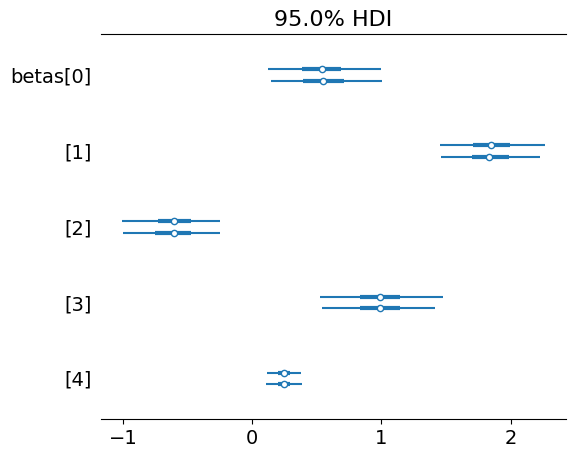

In [ ]:
# Sketch credible intervals
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata, var_names=["betas"], combined=False, hdi_prob=0.95)

HMC Split-Rhats {'betas': array([1.0009, 1.0003, 1.0039, 0.9998, 1.0003])}


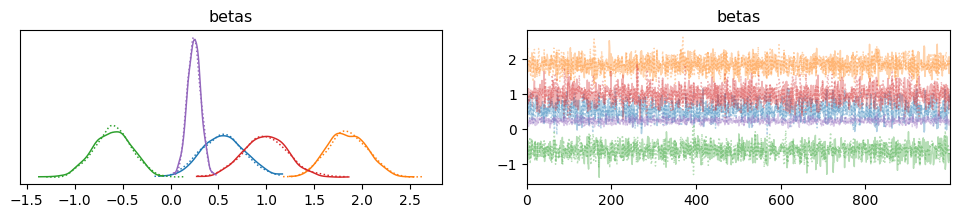

In [ ]:
# Sketch the trace plot
az.plot_trace(idata)
print("HMC Split-Rhats",
 {k: np.round(v.values,4) for k,v in az.rhat(idata).items()})

From the above traceplots for regression coefficient estimates produced from MCMC samples, we can see that the chains overlap pretty well, indicating that we do not have serious convergence issue with our model.

# Homework 6: Part II<br>Regularized Loss Functions

***Machine Learning*** fits models by optimizing penalized ***loss functions***

Two classic regularizations are "ridge" and "lasso" regression, which respectively use $L_2$ and $L_1$ penalty functions

- Lasso: $$\sum_{i=1}^n \frac{1}{2}(y_i-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n \beta_j^2 = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_2^2 $$
- Ridge: $$\sum_{i=1}^n \frac{1}{2}(y-x_i^T\beta_{p \times 1})^2 + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}(y-X\beta)^T(y-X\beta) + \lambda \sum_{j=1}^n |\beta_j| = \frac{1}{2}||y-X\beta||_2^2 + \lambda ||\beta||_1$$
    
Show that for $\sigma=1$ and ***hyperparameters*** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either ***normal*** or ***Laplace*** prior distributions have analagous forms to the above expressions

Now write down and understand the following: "Bayesians do not optimize posterior distributions, they sample from them; but, the posterior distributions are nonetheless 'regularizations' of the likelihood through the prior."

I could not insert the image to this notebook on Github for some reason, so please refer to this link: https://github.com/HarryC493/STA365/blob/main/Homeworks/STA365%20HW6%202.pdf

Sorry for the inconvenience.

The way that I understand the above statement is that, like what I have shown above, by specifying specific priors (taking $\sigma = 1, b_i = 0$ in this case), we can eventually achieve the log posterior that is proportional to the loss functions given by the Ridge and Lasso regression, thus implementing regularization purposes through priors.